## Importing modules
### Seperated between libraries to keep track

In [315]:
import numpy as np

In [316]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

In [317]:
import matplotlib.pyplot as plt
%matplotlib inline

In [318]:
from xgboost import XGBRegressor

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [320]:
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Loading data

### Data has been pre-processed and features pre-selected

In [7]:
"""ALL FEATURES"""
#"""
train = pd.read_csv("../data/data_all_features.csv")

X_test = pd.read_csv("../data/test_all_features.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])[headers]
#"""

In [22]:
"""CORRELATED FEATURES"""
"""
train = pd.read_csv("../data/train_correlated.csv")

X_test = pd.read_csv("../data/test_correlated.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])[headers]
"""

'\ntrain = pd.read_csv("../data/train_correlated.csv")\n\nX_test = pd.read_csv("../data/test_correlated.csv")\nX_test_id = pd.read_csv("../data/raw_test.csv")["Id"]\n\nheaders = X_test.columns\n\ny = train["SalePrice"]\nX = train.drop(columns=["SalePrice"])[headers]\n'

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

## Testing model with an early stopping round

In [38]:
def get_score(n):
    
    model = XGBRegressor(n_estimators = n)
    
    scores = -1 * cross_val_score(model, X, y, 
                              cv = 5, 
                              scoring = "neg_mean_absolute_error",
                              error_score="raise")
    return scores.mean()

In [45]:
results = {}
estimators = range(20, 101, 10)
print(estimators[:])
for i in estimators:
    results[i] = get_score(i)
print(results)

range(20, 110, 10)
{20: 17499.213653146406, 30: 17455.910463934073, 40: 17528.751233411815, 50: 17545.825259524827, 60: 17556.947822131846, 70: 17598.433002461472, 80: 17611.09624090325, 90: 17629.790718642977, 100: 17634.1169333262}


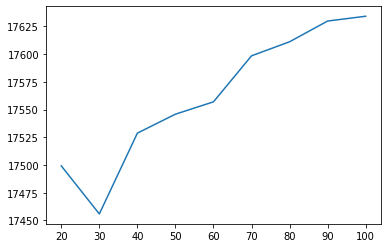

In [46]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [47]:
model = XGBRegressor(n_estimators = 30)
model.fit(X_train, y_train,
          early_stopping_rounds = 10,
          eval_set = [(X_valid, y_valid)], 
          verbose = False
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [26]:
y_test = model.predict(X_test)

submission = pd.DataFrame({"Id":X_test_id, "SalePrice":y_test})

submission.to_csv("../skl-XGBoost/submission.csv", sep =",", index = False)

## Hyperperameter Optimisation

### http://hyperopt.github.io/hyperopt/

hp.choice(label, options) — Returns one of the options, which should be a list or tuple.

hp.randint(label, upper) — Returns a random integer between the range [0, upper).

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [69]:
"""ALL FEATURES"""
"""
train = pd.read_csv("../data/data_all_features.csv")

X_test = pd.read_csv("../data/test_all_features.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])[headers]
X.shape
"""

(1460, 313)

In [294]:
"""CORRELATED FEATURES"""
#"""
train = pd.read_csv("../data/train_correlated.csv")

X_test = pd.read_csv("../data/test_correlated.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y = train["SalePrice"]
X = train.drop(columns=["SalePrice"])[headers]
#"""

In [295]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

In [312]:
"""Linear Regressor"""
def objective(space):
    clf=XGBRegressor(
                    n_estimators = int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
    )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, 
            eval_metric="mae",
            early_stopping_rounds=10,
            verbose=False
           )
    
    print("n_estimators "+str(len(clf.get_booster().get_dump())))

    pred = clf.predict(X_valid)
    accuracy = mean_absolute_error(y_valid, pred)
    print ("SCORE: "+ str(accuracy))
    
    n_est_used = len(clf.get_booster().get_dump())
    
    trials.results[-1]["n_estimators"] = n_est_used
    
    trials.trials[-1]["misc"]["vals"]["n_estimators"] = [n_est_used]
    
    return {'loss': accuracy, 'status': STATUS_OK, "n_estimators" : n_est_used}

In [313]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 999, 1000, 1),
        'seed': 0
    }

In [314]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)
#print(space["n_estimators"])
#print(trials.trials)
#print(trials.results)

n_estimators 64                                                                                                        
SCORE: 20685.661526113014                                                                                              
n_estimators 64                                                                                                        
SCORE: 20919.57719392123                                                                                               
n_estimators 64                                                                                                        
SCORE: 20737.322538527398                                                                                              
n_estimators 64                                                                                                        
SCORE: 21959.460391695204                                                                                              
n_estimators 64                         

In [303]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8098570967501865, 'gamma': 6.814507971661756, 'max_depth': 3.0, 'min_child_weight': 0.0, 'n_estimators': 165, 'reg_alpha': 146.0, 'reg_lambda': 0.5197674257966153}


In [308]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8541948004816649, 'gamma': 2.2362760654700304, 'max_depth': 3.0, 'min_child_weight': 0.0, 'n_estimators': 165, 'reg_alpha': 179.0, 'reg_lambda': 0.9881602240171927}


In [309]:
clf=XGBRegressor(
                n_estimators = int(best_hyperparams["n_estimators"]), 
                max_depth = int(best_hyperparams['max_depth']), 
                gamma = best_hyperparams['gamma'],
                reg_alpha = best_hyperparams['reg_alpha'],
                min_child_weight = best_hyperparams['min_child_weight'],
                colsample_bytree = best_hyperparams['colsample_bytree']
)

clf.fit(X, y, 
        eval_metric="mae",
        verbose=True
)

y_test = clf.predict(X_test)

In [310]:
submission = pd.DataFrame({"Id":X_test_id, "SalePrice":y_test})

submission.to_csv("../skl-XGBoost/submission.csv", sep =",", index = False)